In [1]:
# 导入库包
import datetime
import pandas as pd
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 

In [2]:
#1.读入 分词后的新闻标题、网址及文本 的 Excel档
print('开始时间：' + str(datetime.datetime.now()))

news_df = pd.read_excel('data分词后.xlsx', header=0)

# 检查训练数据是否合规
categories = {'于是':0, '孤独患者':0, '罗生门':0}
i = 0; err = 0
while i < len(news_df):
    if len(str(news_df.分词后内容[i])) < 1: err = err + 1 # 文本少于10个字视为异常
    categories[news_df.歌名[i]] += 1 # 累计各类文本数量
    i = i + 1

# 打印出 各类训练数量、总数量 及 异常数量
print('')
print(categories) 
print('聚类数据数量：' + str(len(news_df)) + '，异常数据数量：' + str(err) 
      + '，结束时间：' + str(datetime.datetime.now()))

# print(news_df[:5])

news_df['情感正向概率'] = ''
news_df['情感归类1'] = ''
news_df['情感归类2'] = ''
news_df['分析用内容'] = ''

print('\n结束时间：' + str(datetime.datetime.now()))

开始时间：2024-12-25 16:08:04.675685

{'于是': 55226, '孤独患者': 56084, '罗生门': 53871}
聚类数据数量：165181，异常数据数量：0，结束时间：2024-12-25 16:08:20.927437

结束时间：2024-12-25 16:08:20.927437


In [3]:
# 随机测试一则文本，将之拆解为单词，放入列表
content0 = news_df.分词后内容[3].split()
print(len(content0))
print(content0)

2
['你常', '牺牲品']


In [4]:
# 试算文本中各个单词的情感得分、总分及平均分数
sentiment_sum=0
for i in range(len(content0)):
    s = SnowNLP(content0[i])
    print(content0[i] + '：' + str(s.sentiments))
    sentiment_sum += s.sentiments
sentiment_avg=sentiment_sum / len(content0)
print ('sentiment_sum：' + str(sentiment_sum))
print ('sentiment_avg：' + str(sentiment_avg))   


你常：0.647058823529412
牺牲品：0.8333333333333333
sentiment_sum：1.4803921568627452
sentiment_avg：0.7401960784313726


In [5]:
#2.计算每一则文本的情感平均分数 (情感正向概率)
print ('2.计算每一则文本的情感正向概率，并统计')
print('开始时间：' + str(datetime.datetime.now()))

# 设置最大、最小的初始值
sentiment_max=0
sentiment_min=1

# 计算每一则文本的情感平均分数 (情感正向概率)
for i in range(len(news_df)):

    words = news_df.分词后内容[i].split()
    # 将总分初始值设为 0
    sentiment_sum=0
    
    for word in words:
        s = SnowNLP(word)
        sentiment_sum = sentiment_sum + s.sentiments
        
    sentiment_avg=sentiment_sum / len(words)
    news_df.loc[i, '情感正向概率'] = sentiment_avg
    
    # 算法一：依据情感得分，从0~1，平均分成五类
    if sentiment_avg < 0.2:
        news_df.loc[i, '情感归类1'] = '1.极端负面'
    elif sentiment_avg < 0.4:
        news_df.loc[i, '情感归类1'] = '2.偏向负面'
    elif sentiment_avg < 0.6:
        news_df.loc[i, '情感归类1'] = '3.情感中性'
    elif sentiment_avg < 0.8:
        news_df.loc[i, '情感归类1'] = '4.偏向正面'
    else: 
        news_df.loc[i, '情感归类1'] = '5.极端正面'
      
    if sentiment_max < sentiment_avg:
        sentiment_max = sentiment_avg
    if sentiment_min > sentiment_avg:
        sentiment_min = sentiment_avg    
    
print('')
print('情感分析数量：' + str(i+1))
print('情感最高分数：' + str(sentiment_max))
print('情感最低分数：' + str(sentiment_min))
print('\n结束时间：' + str(datetime.datetime.now()))

2.计算每一则文本的情感正向概率，并统计
开始时间：2024-12-25 16:08:20.959250

情感分析数量：165181
情感最高分数：1.0
情感最低分数：0.00852065428144888

结束时间：2024-12-25 16:10:54.028218


In [6]:
# 3.依据算法一(情感得分从0~1平均分成五类)，作成交叉分析表
print ('3.依据算法一(情感得分从0~1平均分成五类)，作成交叉分析表')
print('开始时间：' + str(datetime.datetime.now()))
print(' ')

print(pd.crosstab(news_df['情感归类1'], news_df['歌名'], margins=True, margins_name='合计'))

print('\n结束时间：' + str(datetime.datetime.now()))

3.依据算法一(情感得分从0~1平均分成五类)，作成交叉分析表
开始时间：2024-12-25 16:10:54.044343
 
歌名         于是   孤独患者    罗生门      合计
情感归类1                              
1.极端负面    360    303    259     922
2.偏向负面   3095   2684   3138    8917
3.情感中性  19816  19864  18808   58488
4.偏向正面  25905  26248  24190   76343
5.极端正面   6050   6985   7476   20511
合计      55226  56084  53871  165181

结束时间：2024-12-25 16:10:54.138283


In [7]:
#4.依据算法二(情感得分最大到最小平均分成五类)归类
print ('4.依据算法二(情感得分最大到最小平均分成五类)归类')
print('开始时间：' + str(datetime.datetime.now()))

for i in range(len(news_df)):
        
    sentiment_avg = news_df.loc[i, '情感正向概率']

    # 算法二：依据情感得分，从 最小值 到 最大值，平均分成五类
    sentiment_range = sentiment_max - sentiment_min
    sentiment_piece = sentiment_range/5
    
    if sentiment_avg < sentiment_min + sentiment_piece:
        news_df.loc[i, '情感归类2'] = '1.极端负面'
    elif sentiment_avg < sentiment_min + sentiment_piece*2:
        news_df.loc[i, '情感归类2'] = '2.偏向负面'
    elif sentiment_avg < sentiment_min + sentiment_piece*3:
        news_df.loc[i, '情感归类2'] = '3.情感中性'
    elif sentiment_avg < sentiment_min + sentiment_piece*4:
        news_df.loc[i, '情感归类2'] = '4.偏向正面'
    else: 
        news_df.loc[i, '情感归类2'] = '5.极端正面'
    
    news_df.loc[i, '分析用内容'] = news_df.分词后内容[i]

print('结束时间：' + str(datetime.datetime.now()))

4.依据算法二(情感得分最大到最小平均分成五类)归类
开始时间：2024-12-25 16:10:54.146001
结束时间：2024-12-25 16:11:19.395938


In [8]:
# 5.依据算法二(情感得分最大到最小平均分成五类)，作成交叉分析表
print ('5.依据算法二(情感得分最大到最小平均分成五类)，作成交叉分析表')
print('开始时间：' + str(datetime.datetime.now()))
print(' ')

print(pd.crosstab(news_df['情感归类2'], news_df['歌名'], margins=True, margins_name='合计'))

print('\n结束时间：' + str(datetime.datetime.now()))

5.依据算法二(情感得分最大到最小平均分成五类)，作成交叉分析表
开始时间：2024-12-25 16:11:19.403984
 
歌名         于是   孤独患者    罗生门      合计
情感归类2                              
1.极端负面    393    321    286    1000
2.偏向负面   3231   2808   3239    9278
3.情感中性  20195  20329  19276   59800
4.偏向正面  25668  25910  23786   75364
5.极端正面   5739   6716   7284   19739
合计      55226  56084  53871  165181

结束时间：2024-12-25 16:11:19.474528


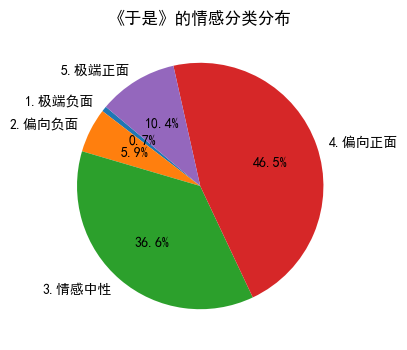

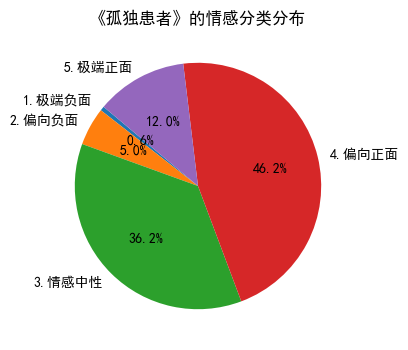

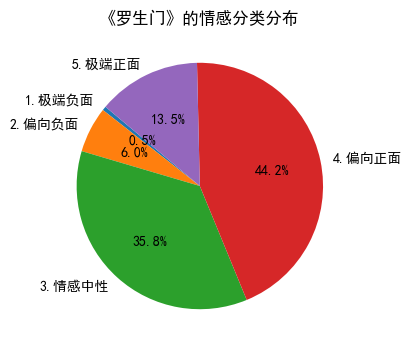

In [13]:
unique_songs = news_df['歌名'].unique()
 
for song in unique_songs:
    song_df = news_df[news_df['歌名'] == song]
    sentiment_counts = song_df['情感归类2'].value_counts()
    
    # 定义所有可能的情感分类，确保它们在饼图中都有表示（即使计数为0）
    all_categories = ['1.极端负面', '2.偏向负面', '3.情感中性', '4.偏向正面', '5.极端正面']
    # 使用reindex并fill_value=0来确保所有分类都在sentiment_counts中，且计数为0的也会被包括
    # 由于reindex可能会改变顺序，我们需要确保之后的使用中顺序是正确的
    # 这里我们直接按all_categories的顺序来创建新的计数字典，而不是依赖reindex后的顺序
    ordered_sentiment_counts = {category: sentiment_counts.get(category, 0) for category in all_categories}
    
    # 将字典转换为列表，以便传递给pie函数
    sizes = list(ordered_sentiment_counts.values())
    labels = list(ordered_sentiment_counts.keys())
    
    # 绘制饼图
    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title(f'《{song}》的情感分类分布')
    plt.show()

In [ ]:
# 6.将情感分析后的 新闻 DataFrame 存入 Excel 档
print ('6.将情感分析后的 新闻 DataFrame 存入 Excel 档')
print('开始时间：' + str(datetime.datetime.now()))

news_df.to_excel('data情感分析后 2024.xlsx', header=True)

print('结束时间：' + str(datetime.datetime.now()))